In [1]:
%ls data/**

data/01-calimag-test:
MS_20200204_Mouse008.nwb  README.md  SD_20210511_Mouse513.nwb

data/02-max-spont:
MS_20220603_ME04.nwb  README.md

data/03-simon-proj:
README.md  preproc/  proc/

data/04-allen-credasgmt:
README.md  sub-411424_ses-20181011T155936_behavior+ophys.nwb


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pynwb import NWBHDF5IO

First let's explore some `calimag` test data in `data/01-calimag-test`

In [4]:
%ls data/01-calimag-test

MS_20200204_Mouse008.nwb  README.md  SD_20210511_Mouse513.nwb


In [5]:
nwb = NWBHDF5IO('data/01-calimag-test/MS_20200204_Mouse008.nwb', 'r').read()
nwb

root pynwb.file.NWBFile at 0x140615673167344
Fields:
  acquisition: {
    flow <class 'pynwb.base.TimeSeries'>,
    wheel <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experimenter: ['']
  file_create_date: [datetime.datetime(2022, 12, 14, 15, 46, 4, 974522, tzinfo=tzoffset(None, -18000))]
  identifier: ace47c20624973e1ac0215782504d770
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Brown University
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: Fleischmann Lab
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: My awesome session
  session_start_time: 2020-02-04 18:01:38.714876-05:00
  stimulus: {
    odor <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at 0x140615673621728
Fields:
  age: 73w (ended)
  date_of_birth: 2019-02-18 00:00:00-05:00
  description: Mouse #8
  genotype: tdTomato +/-
  sex: ma

Acquisition is a place to store raw acquired data, for example raw output from Teensy. Raspberry Pi, even raw Tiff stack and behavior videos if you wish.

In [6]:
nwb.acquisition

{'flow': flow pynwb.base.TimeSeries at 0x140615673164512
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (2400000,), type "<f8">
   description: no description
   interval: 1
   offset: 0.0
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (2400000,), type "<f8">
   timestamps_unit: seconds
   unit: m3/sec,
 'wheel': wheel pynwb.base.TimeSeries at 0x140615673165136
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (2400000,), type "<f8">
   description: no description
   interval: 1
   offset: 0.0
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (2400000,), type "<f8">
   timestamps_unit: seconds
   unit: rad}

See how it looks like a `dict`, so to access the `flow` data, which is a measure of respiratory rate

In [7]:
nwb.acquisition['flow']

flow pynwb.base.TimeSeries at 0x140615673164512
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (2400000,), type "<f8">
  description: no description
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (2400000,), type "<f8">
  timestamps_unit: seconds
  unit: m3/sec

Two main fields that you should focus on are:
- `data`, which stores a time series of the actual data
- `timestamps`, which stores the time stamps of the data

Remember, **time** unites the different data sources. Also, note that this *lacks* `description`, which is not going to be informative for people not familiar with the data. This is why **recording time and saving meta-data are so important**. 

To access a field, use `.` (period/dot) operation

In [8]:
nwb.acquisition['flow'].data

<HDF5 dataset "data": shape (2400000,), type "<f8">

However, this is lazy data loading, which means that the actual data points have not been loaded into memory yet. This is very useful because the data file can be GBs of data but you can choose which data into memory, instead of everything.

You can do that with adding `[:]` and the end

In [9]:
nwb.acquisition['flow'].data[:]

array([0.02562, 0.02568, 0.02556, ..., 0.02238, 0.0225 , 0.0225 ])

In [10]:
nwb.acquisition['flow'].timestamps[:]

array([0.000000e+00, 1.000000e-03, 2.000000e-03, ..., 4.770060e+03,
       4.770061e+03, 4.770062e+03])

Before plotting what the data looks like, let's talk about trials

In [11]:
nwb.trials

trials pynwb.epoch.TimeIntervals at 0x140615673620912
Fields:
  colnames: ['start_time' 'stop_time']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>
  )
  description: experimental trials
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

Everytime you see an object that has `colnames` and `columns`, you can bet that this is a table. 

So how do we get it to a more friendly data frame, so that we can use it with our favorite `pandas`?

Append `.to_dataframe()`

In [12]:
nwb.trials.to_dataframe()

start_time  stop_time
id                       
0        0.000     29.999
1       60.006     90.005
2      120.003    150.002
3      180.005    210.004
4      240.005    270.004
..         ...        ...
75    4500.060   4530.059
76    4560.067   4590.066
77    4620.066   4650.065
78    4680.061   4710.060
79    4740.063   4770.062

[80 rows x 2 columns]

In addition you can get a description of these columns like this

In [13]:
nwb.trials.start_time.description

'Start time of epoch, in seconds'

So we can use this to split the trials. Here's a simple function to achieve that. 

However, note that this is not the only or optimal way, there are better ways if the data are saved the right way. More on this is the future. 

In [14]:
def split_by_trial(nwb, data, time, axis=0, reshift_time=True):
    """
    Split `data` (in `axis` [default: `0`] axis as `data` time axis) 
    extracted from `nwb` object into trials, using `time` array.
    
    If `reshift_time` [default: `True`], each trial's time vector
    will be offset to begin at 0.
    
    Returns: list of `data_by_trial` and `time_by_trial`
    """
    data_by_trial, time_by_trial = [], []
    for _, row in nwb.trials.to_dataframe().iterrows():
        trial = (time >= row.start_time) & (time <= row.stop_time)
        _data = np.take(data, np.where(trial)[0], axis=axis)
        _time = time[trial]        
        if reshift_time:
            _time -= _time[0]            
        data_by_trial.append(_data)
        time_by_trial.append(_time)
    return data_by_trial, time_by_trial 

Let's split our `flow` into trials

In [15]:
flow_data, flow_time = split_by_trial(
    nwb, 
    data = nwb.acquisition['flow'].data[:],
    time = nwb.acquisition['flow'].timestamps[:]
)
    
                                      

`flow_data` & `flow_time`are lists of 80 trials

In [16]:
print(len(flow_data))
print(len(flow_time))

80
80


Let's plot one of the trials

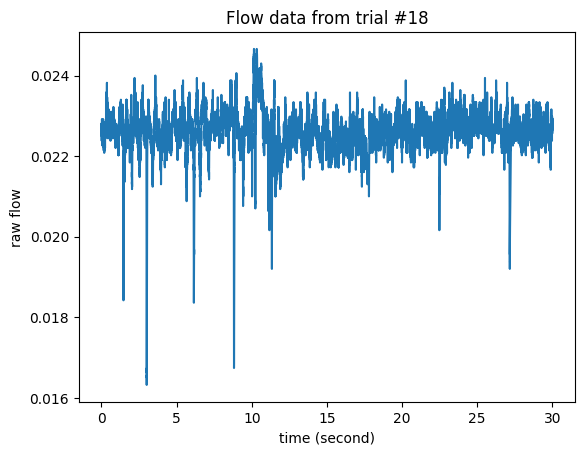

In [17]:
trial_id = 18
plt.plot(
    flow_time[trial_id],
    flow_data[trial_id]
)
plt.xlabel('time (second)')
plt.ylabel('raw flow')
plt.title(f'Flow data from trial #{trial_id}')
plt.show()

Ok, but where is our stimulus? 

You can access that with `stimulus` field of `nwb` variable. 

And there's only one here called `odor`, which conatins odor identity time series of all trials

In [18]:
nwb.stimulus

{'odor': odor pynwb.base.TimeSeries at 0x140615673166624
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (2400000,), type "<f8">
   description: no description
   interval: 1
   offset: 0.0
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (2400000,), type "<f8">
   timestamps_unit: seconds
   unit: -}

Let's attempt to also split this into trials as well

In [19]:
odor_data, odor_time = split_by_trial(
    nwb, 
    data = nwb.stimulus['odor'].data[:],
    time = nwb.stimulus['odor'].timestamps[:]
)                                      

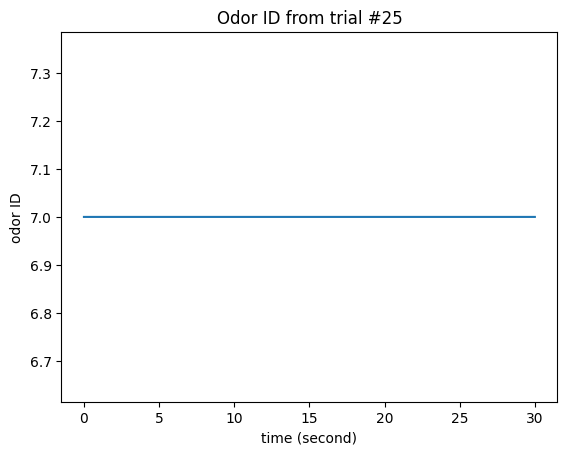

In [20]:
trial_id = 25
plt.plot(
    odor_time[trial_id],
    odor_data[trial_id]
)
plt.xlabel('time (second)')
plt.ylabel('odor ID')
plt.title(f'Odor ID from trial #{trial_id}')
plt.show()

This is actually just one constant value of ID = 7

Since it's redudant to have a bunch of similar numbers per trial, we can also write a function to extract the odor ID per trials

In [21]:
def extract_odor(nwb):
    """
    Extract odor identities from `nwb` object per trial
    Returns: a `numpy.array` of odors, each element is a trial
    """
    odor = nwb.stimulus['odor']
    odor, _ = split_by_trial(nwb, odor.data[:], odor.timestamps[:])
    odor = list(map(np.unique, odor))
    assert all([len(x) == 1 for x in odor]), 'Some trials have multiple odors'
    return np.array(odor).flatten().astype('int')

In [22]:
odor_ids = extract_odor(nwb)

In [23]:
odor_ids

array([ 4,  6,  7,  5,  3,  1,  2, 10,  9,  8,  6,  4,  9,  5,  8,  1, 10,
        7,  3,  2,  9,  5,  8,  2,  1,  7, 10,  3,  4,  6,  7,  5,  4, 10,
        9,  1,  3,  8,  2,  6,  9,  5,  8,  4,  1,  7,  3, 10,  2,  6,  3,
        5,  8,  4,  1,  7,  9, 10,  2,  6,  4,  5,  1,  2,  6,  7,  9,  8,
        3, 10,  8,  4,  1,  2,  6,  3,  7,  5, 10,  9])

> Where is neural activity? Is this even neuroscience? Where's the `N` in `NWB`?

Glad you asked. But first let's load in another file (just because we can)

In [24]:
nwb = NWBHDF5IO('data/01-calimag-test/SD_20210511_Mouse513.nwb', 'r').read()
nwb

root pynwb.file.NWBFile at 0x140616832157056
Fields:
  acquisition: {
    wheel <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2022, 12, 14, 15, 57, 48, 696074, tzinfo=tzoffset(None, -18000))]
  identifier: cd5cc4a1570e336268ea1a4a62e90b26
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: Weeds
  session_start_time: 2021-05-11 14:57:25.952809-05:00
  stimulus: {
    odor <class 'pynwb.base.TimeSeries'>
  }
  timestamps_reference_time: 2021-05-11 14:57:25.952809-05:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>

Here you go, `ophys` is short for Optical Physiology, which is saved in `processing`.

Why? because technically this is output from a preprocessing package (`suite2p`).
 
`processing` is the place where you would find most of the data you'd need when working with `nwb` files.

In [25]:
ophys = nwb.processing['ophys']
ophys

ophys pynwb.base.ProcessingModule at 0x140616832160800
Fields:
  data_interfaces: {
    Backgrounds_0 <class 'pynwb.base.Images'>,
    Backgrounds_1 <class 'pynwb.base.Images'>,
    Backgrounds_2 <class 'pynwb.base.Images'>,
    Deconvolved <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence_chan2 <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    Neuropil <class 'pynwb.ophys.Fluorescence'>,
    Neuropil_chan2 <class 'pynwb.ophys.Fluorescence'>
  }
  description: optical physiology processed data from suite2p

In [26]:
ophys['Fluorescence']

Fluorescence pynwb.ophys.Fluorescence at 0x140616832169104
Fields:
  roi_response_series: {
    Plane_0 <class 'pynwb.ophys.RoiResponseSeries'>,
    Plane_1 <class 'pynwb.ophys.RoiResponseSeries'>,
    Plane_2 <class 'pynwb.ophys.RoiResponseSeries'>
  }

Every time you see an object that has one "data" field. You can access the inside objects with 2 ways

In [27]:
# the full way
ophys['Fluorescence'].roi_response_series['Plane_0']

Plane_0 pynwb.ophys.RoiResponseSeries at 0x140616832253520
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (10000, 207), type "<f4">
  description: no description
  interval: 1
  offset: 0.0
  resolution: -1.0
  rois: rois <class 'hdmf.common.table.DynamicTableRegion'>
  timestamps: <HDF5 dataset "timestamps": shape (10000,), type "<f8">
  timestamps_unit: seconds
  unit: lumens

In [28]:
# the short way
ophys['Fluorescence']['Plane_0']

Plane_0 pynwb.ophys.RoiResponseSeries at 0x140616832253520
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (10000, 207), type "<f4">
  description: no description
  interval: 1
  offset: 0.0
  resolution: -1.0
  rois: rois <class 'hdmf.common.table.DynamicTableRegion'>
  timestamps: <HDF5 dataset "timestamps": shape (10000,), type "<f8">
  timestamps_unit: seconds
  unit: lumens

Notice this plane has 207 ROI, recorded for 10000 data points

Here's a function to split flouresence data into trials and compute `dF` like how `suite2p` suggests, which is:

$$ \mathtt{dF} = \mathtt{Flourescence} - 0.7 \times \mathtt{Neuropil}$$

We can also use `iscell` from `suite2p` and combine planes as well.

In [29]:
def compute_dF(nwb, k_neu=0.7, combine_planes=True, use_iscell=True, split_trial=True): 
    """
    Compute dF from fluorescence data inside `nwb`, separated by trials if `split_trial`
    
    - `k_neu`: [default: `0.7`] scalar to subtract neutropil, i.e. `F = F - k_neu x F_neu`
    - `combine_planes`: [default: `True`] whether to combine all the planes in one dataset.
        Warning: the timings of different planes are not aligned, and 
        and there is no alignment/reshifting/resampling happening here.
        If `False`, there will be a field in the sub-dict to indicate each field
    - `use_iscell`: [default: `True`] whether to use `iscell` from `suite2p` output
    - `split_trial`: [default: `True`] whether to split by trial,
        Note: currently to split trials, the timestamps of the first plane is used,
        see <https://gitlab.com/fleischmann-lab/calcium-imaging/calimag/-/issues/92>
            
    Returns: a dict of `info` (the params), `t` (time) and `dF` data of
    - (not `split_trial`, not `combine_planes`): each sub-dict of planes contains `all_times x rois_per_plane`
    - (`split_trial`, not `combine_planes`): each sub-dict of planes contains `list[times_per_trial x rois_per_plane]` (`len = num_trials`)
    - (not `split_trial`, `combine_planes`): array of `all_times x all_rois`, by concatenating ROIs across planes
    - (`split_trial`, `combine_planes`): `list[times_per_trial x all_rois]` (`len = num_trials`)    
    """
    
    F = nwb.processing['ophys']['Fluorescence']
    Fneu = nwb.processing['ophys']['Neuropil']
    planes = sorted(F.roi_response_series.keys())
    
    if use_iscell: 
        iscell = nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']['iscell'].data[:,0] > 0
        nc_roi = 0
        
    output = dict(
        dF = dict(),
        t = dict(),
        info = dict(
            k_neu = k_neu,
            combine_planes = combine_planes,
            use_iscell = use_iscell,
            split_trial = split_trial,
        )
    )
    
    for i, p in enumerate(planes):
        F_p = F[p].data[:]
        Fn_p = Fneu[p].data[:]
        t_p = F[p].timestamps[:]
        assert all(t_p - Fneu[p].timestamps[:] == 0)
        Fs = 1/(t_p[1] - t_p[0])
        
        if i == 0: 
            t_p0 = t_p
            
        if use_iscell:
            cell_mask = iscell[nc_roi:nc_roi+F_p.shape[1]]
            nc_roi += F_p.shape[1]
            
            F_p = F_p[:,cell_mask]
            Fn_p = Fn_p[:,cell_mask]
            
        F0_p = k_neu * Fn_p
        activ_p = F_p - F0_p
        
        # uncomment below to z-score
        # activ_p = StandardScaler().fit_transform(activ_p)
        
        if split_trial:
            # reference time is from first plane, 
            # currently plane_3 last time per trial is tinily > stop_time of that trial
            activ_p, t_p = split_by_trial(nwb, activ_p, t_p0)

        output['dF'][p] = activ_p       
        output['t'][p] = t_p
        
    p0 = list(output['t'].keys())[0]
        
    if combine_planes:
        if not split_trial:
            output['dF'] = np.hstack(list(output['dF'].values()))
        else:
            num_trials = len(output['dF'][p0])
            output['dF'] = [
                np.hstack(list(
                    map(lambda x: x[trial], 
                        output['dF'].values()
                       )))
                for trial in range(num_trials)
            ]
        output['t'] = output['t'][p0]

    return output


In [30]:
dF_data = compute_dF(nwb)

In [31]:
print('number of trials =', len(dF_data['dF']))
print('size of data (time x roi) =', dF_data['dF'][0].shape)
print('resulting sampling rate after combing (Hz) =', 1/np.diff(dF_data['t'][0])[0])

number of trials = 100
size of data (time x roi) = (100, 267)
resulting sampling rate after combing (Hz) = 4.513074100371255


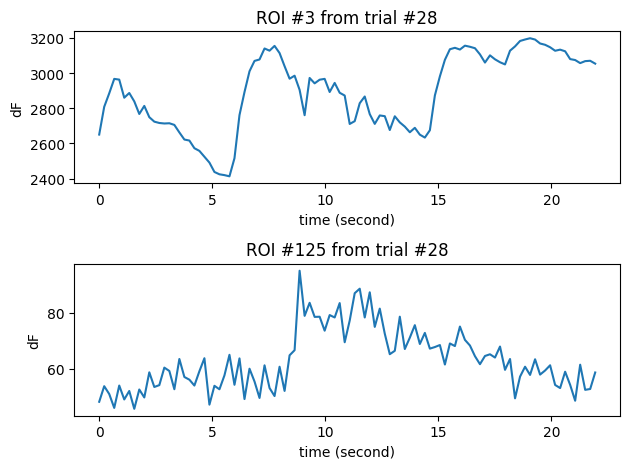

In [32]:
trial_id = 28
roi_ids = [3, 125]

for i, roi_id in enumerate(roi_ids):
    plt.subplot(len(roi_ids), 1, i+1)
    plt.plot(
        dF_data['t'][trial_id],
        dF_data['dF'][trial_id][:, roi_id]
    )
    plt.xlabel('time (second)')
    plt.ylabel('dF')
    plt.title(f'ROI #{roi_id} from trial #{trial_id}')
plt.tight_layout()
plt.show()


What about backgrounds like maximum projection and mean images from registration?

In [33]:
ophys

ophys pynwb.base.ProcessingModule at 0x140616832160800
Fields:
  data_interfaces: {
    Backgrounds_0 <class 'pynwb.base.Images'>,
    Backgrounds_1 <class 'pynwb.base.Images'>,
    Backgrounds_2 <class 'pynwb.base.Images'>,
    Deconvolved <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence_chan2 <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    Neuropil <class 'pynwb.ophys.Fluorescence'>,
    Neuropil_chan2 <class 'pynwb.ophys.Fluorescence'>
  }
  description: optical physiology processed data from suite2p

In [34]:
ophys['Backgrounds_0']

Backgrounds_0 pynwb.base.Images at 0x140616832160608
Fields:
  description: no description
  images: {
    Vcorr <class 'pynwb.image.GrayscaleImage'>,
    max_proj <class 'pynwb.image.GrayscaleImage'>,
    meanImg <class 'pynwb.image.GrayscaleImage'>,
    meanImg_chan2 <class 'pynwb.image.GrayscaleImage'>
  }

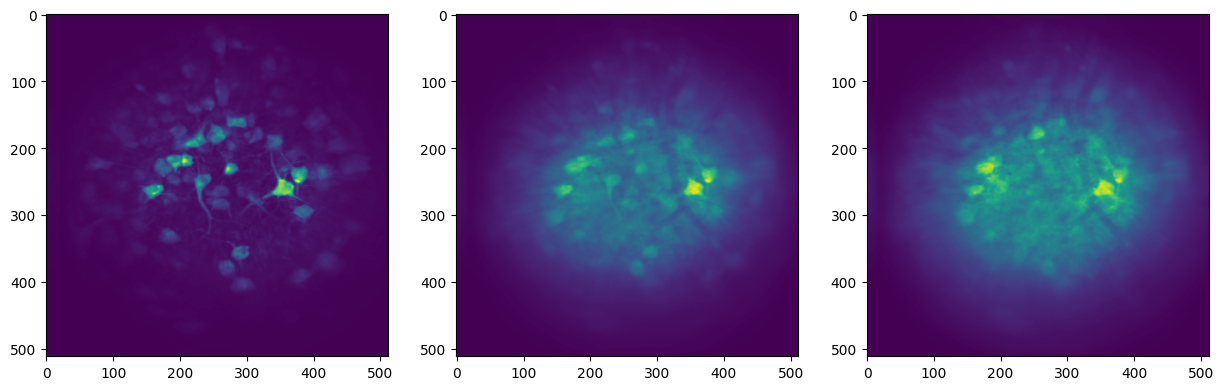

In [35]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(ophys['Backgrounds_0']['max_proj'].data)

plt.subplot(1,3,2)
plt.imshow(ophys['Backgrounds_0']['meanImg'].data)

plt.subplot(1,3,3)
plt.imshow(ophys['Backgrounds_0']['meanImg_chan2'].data)

plt.show()

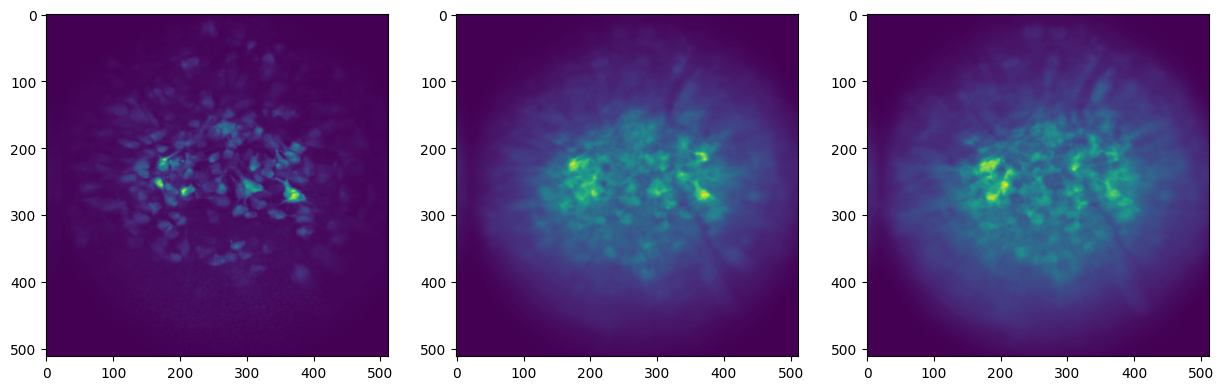

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(ophys['Backgrounds_1']['max_proj'].data)

plt.subplot(1,3,2)
plt.imshow(ophys['Backgrounds_1']['meanImg'].data)

plt.subplot(1,3,3)
plt.imshow(ophys['Backgrounds_1']['meanImg_chan2'].data)

plt.show()

What about ROI?

In [37]:
ophys

ophys pynwb.base.ProcessingModule at 0x140616832160800
Fields:
  data_interfaces: {
    Backgrounds_0 <class 'pynwb.base.Images'>,
    Backgrounds_1 <class 'pynwb.base.Images'>,
    Backgrounds_2 <class 'pynwb.base.Images'>,
    Deconvolved <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence_chan2 <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    Neuropil <class 'pynwb.ophys.Fluorescence'>,
    Neuropil_chan2 <class 'pynwb.ophys.Fluorescence'>
  }
  description: optical physiology processed data from suite2p

In [38]:
ophys['ImageSegmentation']

ImageSegmentation pynwb.ophys.ImageSegmentation at 0x140616832167040
Fields:
  plane_segmentations: {
    PlaneSegmentation <class 'pynwb.ophys.PlaneSegmentation'>
  }

In [39]:
ophys['ImageSegmentation']['PlaneSegmentation']

PlaneSegmentation pynwb.ophys.PlaneSegmentation at 0x140616832160224
Fields:
  colnames: ['voxel_mask' 'iscell']
  columns: (
    voxel_mask_index <class 'hdmf.common.table.VectorIndex'>,
    voxel_mask <class 'hdmf.common.table.VectorData'>,
    iscell <class 'hdmf.common.table.VectorData'>
  )
  description: suite2p output
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x140616832165984
Fields:
  conversion: 1.0
  description: My awesome imaging plane
  device: Microscope pynwb.device.Device at 0x140616832167232
  excitation_lambda: 960.0
  imaging_rate: 4.53
  indicator: jGCaMP7f
  location: PCX
  optical_channel: (
    OpticalChannel <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters


In [40]:
roi_df = ophys['ImageSegmentation']['PlaneSegmentation'].to_dataframe()
roi_df

voxel_mask  \
id                                                       
0    [[140, 258, 0, 0.24322979], [140, 259, 0, 0.26...   
1    [[219, 269, 0, 0.53019935], [219, 270, 0, 0.60...   
2    [[211, 179, 0, 0.41423714], [211, 180, 0, 0.39...   
3    [[195, 329, 0, 0.2943114], [195, 330, 0, 0.363...   
4    [[195, 345, 0, 0.58351934], [196, 345, 0, 0.81...   
..                                                 ...   
664  [[33, 87, 2, 0.46375299], [33, 88, 2, 0.579114...   
665  [[455, 66, 2, 0.078933135], [455, 67, 2, 0.273...   
666  [[58, 83, 2, 0.1976755], [58, 84, 2, 0.1744532...   
667  [[475, 405, 2, 0.14721929], [475, 406, 2, 0.26...   
668  [[210, 229, 2, 0.7792294], [210, 230, 2, 0.739...   

                         iscell  
id                               
0     [1.0, 0.8182523630350004]  
1     [1.0, 0.8925545699357915]  
2     [1.0, 0.7300222378925639]  
3     [1.0, 0.7990837648638905]  
4      [1.0, 0.525901682400488]  
..                          ...  
664   [0.0, 0.8246578210457957]  
665  [0.0, 0.09573849317013353]  
666   [0.0, 0.4234607401629184]  
667  [0.0, 0.06817187593427233]  
668   [1.0, 0.9233360521803713]  

[669 rows x 2 columns]

This contains all planes, FYI. So the ROI index here is more like "global" index instead of index per plane.

Let's try one of them

In [41]:
roi_df = ophys['ImageSegmentation']['PlaneSegmentation'].to_dataframe()

In [42]:
roi_ind = 9
roi_coord = pd.DataFrame(roi_df.iloc[roi_ind].voxel_mask)
roi_coord

x    y  z    weight
0    214  173  0  0.498846
1    214  174  0  0.490598
2    215  169  0  0.667309
3    215  170  0  0.868966
4    215  171  0  1.014711
..   ...  ... ..       ...
281  235  167  0  1.365566
282  235  168  0  1.448810
283  235  169  0  1.393739
284  235  170  0  1.183736
285  235  174  0  1.321169

[286 rows x 4 columns]

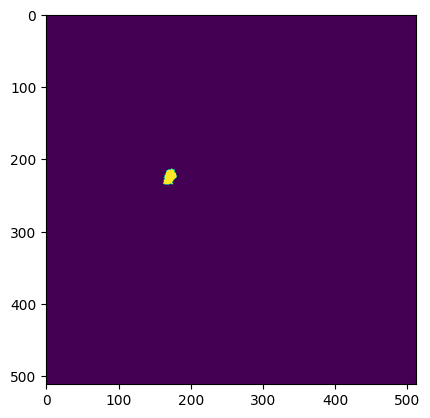

In [43]:
im = np.zeros_like(ophys['Backgrounds_1']['meanImg'].data)
im[roi_coord.x.to_list(),roi_coord.y.to_list()] = 1
plt.imshow(im)
plt.show()